In [1]:
import numpy as np
import pandas as pd
from scipy.spatial import distance as dist
import matplotlib.pyplot as plt
import os
import cv2
import seaborn as sns
from tqdm import tqdm 
from sklearn.utils import shuffle
from sklearn import decomposition
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.applications.vgg16 import VGG16 
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.layers import Lambda, SeparableConv2D, BatchNormalization, Dropout, MaxPooling2D, Input, Dense, Conv2D, Activation, Flatten 
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import imutils

In [2]:
train_root  = "D:/1/NTU_AI_Lab/Final Project/Blood Cell Images/dataset2-master/dataset2-master/images/TRAIN"
test_root = "D:/1/NTU_AI_Lab/Final Project/Blood Cell Images/dataset2-master/dataset2-master/images/TEST"

In [3]:
class_names = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']
nb_classes = len(class_names)
image_size = (120,160)

In [4]:
def findEdges(image):
    # find edges in image
    gray = cv2.GaussianBlur(image, (1, 1), 0)
    edged = cv2.Canny(gray, 100, 400)
    edged = cv2.dilate(edged, None, iterations=1)
    edged = cv2.erode(edged, None, iterations=1)
    return edged

def getImgContours(edged):
    # find contours in the edge map
    contours = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    contours = sorted(contours, key=lambda x: cv2.contourArea(x))
    return contours

def getBoxes(contours, orig):
    # get the boxes
    boxes = []
    centers = []
    for contour in contours:
        box = cv2.minAreaRect(contour)
        box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
        box = np.array(box, dtype="int")
        (tl, tr, br, bl) = box
        if (dist.euclidean(tl, bl)) > 0 and (dist.euclidean(tl, tr)) > 0:
            boxes.append(box)
    return boxes

def load_data(root):

    datasets = [root]
    images = []
    labels = []

    # iterate through training and test sets
    count =0
    for dataset in datasets:

        # iterate through folders in each dataset
        for folder in os.listdir(dataset):

            if folder in ['EOSINOPHIL']: label = 0
            elif folder in ['LYMPHOCYTE']: label = 1
            elif folder in ['MONOCYTE']: label = 2
            elif folder in ['NEUTROPHIL']: label = 3

            # iterate through each image in folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):

                # get pathname of each image
                img_path = os.path.join(os.path.join(dataset, folder), file)

                # Open 
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                # add padding to the image to better detect cell at the edge
                image = cv2.copyMakeBorder(image,10,10,10,10,cv2.BORDER_CONSTANT,value=[198, 203, 208])
                
                #thresholding the image to get the target cell
                image1 = cv2.inRange(image,(80, 80, 180),(180, 170, 245))
                
                # openning errosion then dilation
                kernel = np.ones((3, 3), np.uint8)
                kernel1 = np.ones((5, 5), np.uint8)
                img_erosion = cv2.erode(image1, kernel, iterations=2)
                image1 = cv2.dilate(img_erosion, kernel1, iterations=5)
                
                #detecting the blood cell
                edgedImage = findEdges(image1)
                edgedContours = getImgContours(edgedImage)
                edgedBoxes =  getBoxes(edgedContours, image.copy())
                if len(edgedBoxes)==0:
                    count +=1
                    continue
                # get the large box and get its cordinate
                last = edgedBoxes[-1]
                max_x = int(max(last[:,0]))
                min_x = int( min(last[:,0]))
                max_y = int(max(last[:,1]))
                min_y = int(min(last[:,1]))
                
                # draw the contour and fill it 
                mask = np.zeros_like(image)
                cv2.drawContours(mask, edgedContours, len(edgedContours)-1, (255,255,255), -1) 
                
                # any pixel but the pixels inside the contour is zero
                image[mask==0] = 0
                
                # extract th blood cell
                image = image[min_y:max_y, min_x:max_x]

                if (np.size(image)==0):
                    count +=1
                    continue
                # resize th image
                image = cv2.resize(image, image_size)

                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)

    images = np.array(images, dtype = 'float32')
    labels = np.array(labels, dtype = 'int32')

    return images, labels

def display_examples(class_names, images, labels):
    fig = plt.figure(figsize = (10,10))
    fig.suptitle("Examples of images in the dataset", fontsize=16)
    n = 0
    for i in range(4):
        for j in range(5):
            plt.subplot(4,5,i*5+j+1)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            while labels[n]!=i:
                n = n + 1
            plt.imshow(images[n], cmap=plt.cm.binary)
            plt.xlabel(class_names[labels[n]])
            n = n + 1


In [5]:
images, labels = load_data(train_root)

100%|█████████████████████████████████████████████████████████████████████████████| 2499/2499 [00:13<00:00, 192.11it/s]


In [6]:
test_images, test_labels = load_data(test_root)

100%|███████████████████████████████████████████████████████████████████████████████| 624/624 [00:01<00:00, 312.90it/s]


In [7]:
images, labels = shuffle(images, labels)
test_images, test_labels = shuffle(test_images, test_labels)

In [8]:
train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size = 0.2)

In [9]:
train_images = train_images / 255.0 
val_images = val_images / 255.0
test_images = test_images / 255.0

In [27]:
print(np.shape(train_images))
print(np.shape(train_labels))
print(np.shape(val_images))
print(np.shape(val_labels))

(7776, 160, 120, 3)
(7776,)
(1944, 160, 120, 3)
(1944,)


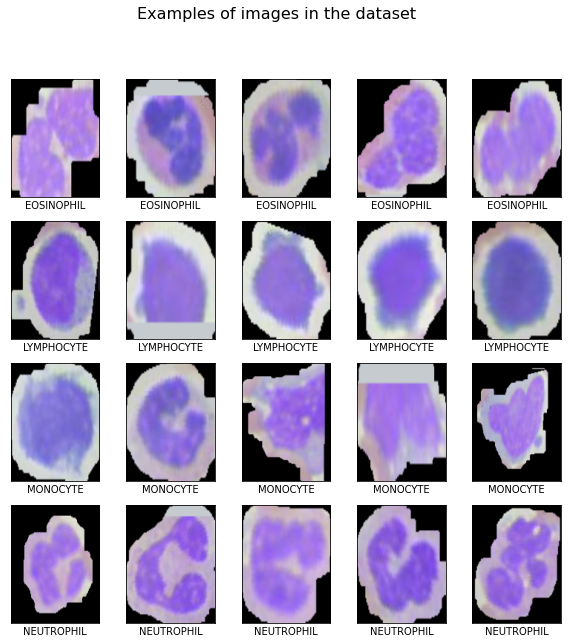

In [10]:
display_examples(class_names, train_images, train_labels)

AlexNet

In [44]:
model = Sequential()

model.add(Conv2D(filters=96,kernel_size=11,strides=4, input_shape=(160,120, 3),activation='relu'))
model.add(MaxPooling2D(pool_size=3, strides=2))
model.add(Conv2D(filters=256,kernel_size=5,padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=3, strides=2))
model.add(Conv2D(filters=384,kernel_size=3,padding='same',activation='relu'))
model.add(Conv2D(filters=384,kernel_size=3,padding='same',activation='relu'))
model.add(Conv2D(filters=256,kernel_size=3,padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=3, strides=2))
model.add(Flatten())
model.add(Dense(4096,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4,activation='softmax'))

model.summary()


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_44 (Conv2D)          (None, 38, 28, 96)        34944     
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 18, 13, 96)       0         
 g2D)                                                            
                                                                 
 conv2d_45 (Conv2D)          (None, 18, 13, 256)       614656    
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 8, 6, 256)        0         
 g2D)                                                            
                                                                 
 conv2d_46 (Conv2D)          (None, 8, 6, 384)         885120    
                                                                 
 conv2d_47 (Conv2D)          (None, 8, 6, 384)       

In [45]:
model.compile(optimizer = "adam" , loss = 'sparse_categorical_crossentropy' , metrics = ['accuracy'])
history1 = model.fit(train_images, train_labels, batch_size = 32, epochs = 30, validation_data=(val_images, val_labels))

Epoch 1/30
243/243 [==============================] - 97s 396ms/step - loss: 1.4016 - accuracy: 0.2638 - val_loss: 1.3802 - val_accuracy: 0.2845
Epoch 2/30
243/243 [==============================] - 94s 389ms/step - loss: 1.3194 - accuracy: 0.3467 - val_loss: 1.2588 - val_accuracy: 0.3873
Epoch 3/30
243/243 [==============================] - 94s 389ms/step - loss: 1.2084 - accuracy: 0.4255 - val_loss: 1.1454 - val_accuracy: 0.4851
Epoch 4/30
243/243 [==============================] - 94s 385ms/step - loss: 1.1278 - accuracy: 0.4798 - val_loss: 1.0736 - val_accuracy: 0.5113
Epoch 5/30
243/243 [==============================] - 92s 380ms/step - loss: 1.0531 - accuracy: 0.5208 - val_loss: 1.0506 - val_accuracy: 0.5417
Epoch 6/30
243/243 [==============================] - 91s 373ms/step - loss: 0.9848 - accuracy: 0.5646 - val_loss: 1.0038 - val_accuracy: 0.5622
Epoch 7/30
243/243 [==============================] - 91s 376ms/step - loss: 0.8949 - accuracy: 0.6070 - val_loss: 1.0031 - val_ac

In [54]:
score = model.evaluate(test_images,test_labels)
print(score)

76/76 [==============================] - 6s 81ms/step - loss: 3.1344 - accuracy: 0.4481
[3.134385585784912, 0.4480626583099365]


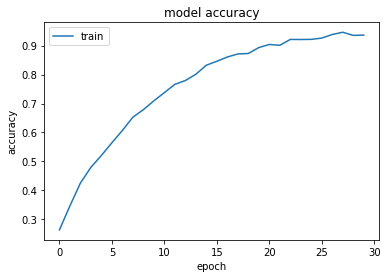

In [56]:
import matplotlib.pyplot as plt
plt.plot(history1.history['accuracy'])
# #plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


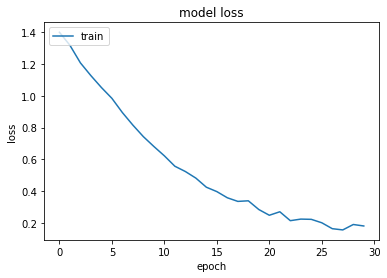

In [58]:
plt.plot(history1.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


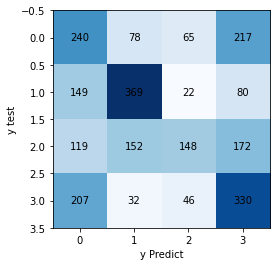

In [60]:
from sklearn.metrics import confusion_matrix
pred = np.argmax(model.predict(test_images),axis=1)
cm = confusion_matrix(test_labels, pred)
# Plot confusion matrix
plt.imshow(cm,interpolation='none',cmap='Blues')
for (i, j), z in np.ndenumerate(cm):
    plt.text(j, i, z, ha='center', va='center')
plt.xlabel("y Predict")
plt.ylabel("y test")
plt.grid(False)
plt.show()

Resnet

In [46]:
# Using Resnet
import keras
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.models import Model

restnet = ResNet50(include_top=False, weights='imagenet', input_shape=(160,120,3))
restnet.summary()

from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers
model2 = Sequential()
model2.add(restnet)
model2.add(Flatten())
model2.add(Dense(512, activation='relu'))
model2.add(Dropout(0.3))
model2.add(Dense(64, activation='relu'))
model2.add(Dropout(0.3))
model2.add(Dense(4, activation='softmax'))



Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 166, 126, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 80, 60, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 80, 60, 64)   256         ['conv1_conv[0][0]']      

In [47]:
model2.compile(optimizer = "adam" , loss = 'sparse_categorical_crossentropy' , metrics = ['accuracy'])
history2 = model2.fit(train_images, train_labels, batch_size = 32, epochs = 15, validation_data=(val_images, val_labels))

Epoch 1/15
243/243 [==============================] - 1054s 4s/step - loss: 0.9160 - accuracy: 0.7311 - val_loss: 4.8317 - val_accuracy: 0.3380
Epoch 2/15
243/243 [==============================] - 1053s 4s/step - loss: 0.3494 - accuracy: 0.8787 - val_loss: 1.3807 - val_accuracy: 0.3014
Epoch 3/15
243/243 [==============================] - 1045s 4s/step - loss: 0.2798 - accuracy: 0.9038 - val_loss: 5.4994 - val_accuracy: 0.2551
Epoch 4/15
243/243 [==============================] - 1040s 4s/step - loss: 0.4889 - accuracy: 0.8552 - val_loss: 7.8117 - val_accuracy: 0.3328
Epoch 5/15
243/243 [==============================] - 1037s 4s/step - loss: 0.4598 - accuracy: 0.8660 - val_loss: 654.2601 - val_accuracy: 0.2361
Epoch 6/15
243/243 [==============================] - 1042s 4s/step - loss: 0.2337 - accuracy: 0.9228 - val_loss: 1.1224 - val_accuracy: 0.7762
Epoch 7/15
243/243 [==============================] - 1038s 4s/step - loss: 0.1956 - accuracy: 0.9299 - val_loss: 20.3226 - val_accura

In [48]:
score2 = model2.evaluate(test_images,test_labels)
print(score2)

76/76 [==============================] - 69s 913ms/step - loss: 0.4778 - accuracy: 0.8516
[0.4778290390968323, 0.8516075611114502]


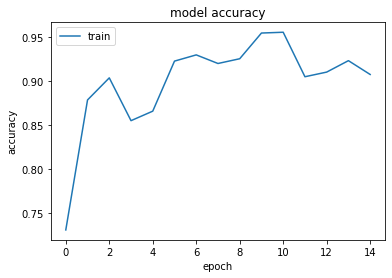

In [49]:
plt.plot(history2.history['accuracy'])
# #plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


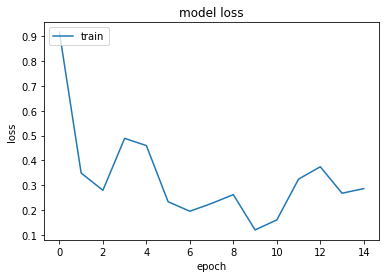

In [50]:
plt.plot(history2.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

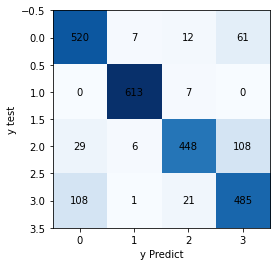

In [59]:
from sklearn.metrics import confusion_matrix
pred2 = np.argmax(model2.predict(test_images),axis=1)
cm2 = confusion_matrix(test_labels, pred2)
# Plot confusion matrix
plt.imshow(cm2,interpolation='none',cmap='Blues')
for (i, j), z in np.ndenumerate(cm2):
    plt.text(j, i, z, ha='center', va='center')
plt.xlabel("y Predict")
plt.ylabel("y test")
plt.grid(False)
plt.show()

AlexNet_tiny

In [61]:
model3 = Sequential()

model3.add(Conv2D(filters=48,kernel_size=5, input_shape=(160,120, 3),activation='relu'))
model3.add(MaxPooling2D(pool_size=3))
model3.add(Conv2D(filters=128,kernel_size=5,padding='same',activation='relu'))
model3.add(MaxPooling2D(pool_size=3))
model3.add(Conv2D(filters=64,kernel_size=3,padding='same',activation='relu'))
model3.add(Conv2D(filters=128,kernel_size=3,padding='same',activation='relu'))
model3.add(Conv2D(filters=64,kernel_size=3,padding='same',activation='relu'))
model3.add(MaxPooling2D(pool_size=3))
model3.add(Flatten())
model3.add(Dense(1024,activation='relu'))
model3.add(Dropout(0.25))
model3.add(Dense(64,activation='relu'))
model3.add(Dropout(0.25))
model3.add(Dense(4,activation='softmax'))

model3.summary()


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_49 (Conv2D)          (None, 156, 116, 48)      3648      
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 52, 38, 48)       0         
 g2D)                                                            
                                                                 
 conv2d_50 (Conv2D)          (None, 52, 38, 128)       153728    
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 17, 12, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_51 (Conv2D)          (None, 17, 12, 64)        73792     
                                                                 
 conv2d_52 (Conv2D)          (None, 17, 12, 128)     

In [64]:
model3.compile(optimizer = "adam" , loss = 'sparse_categorical_crossentropy' , metrics = ['accuracy'])
history3 = model3.fit(train_images, train_labels, batch_size = 32, epochs = 30, validation_data=(val_images, val_labels))

Epoch 1/30
243/243 [==============================] - 161s 660ms/step - loss: 0.6975 - accuracy: 0.6811 - val_loss: 0.5357 - val_accuracy: 0.7495
Epoch 2/30
243/243 [==============================] - 188s 772ms/step - loss: 0.5102 - accuracy: 0.7753 - val_loss: 0.5127 - val_accuracy: 0.7865
Epoch 3/30
243/243 [==============================] - 184s 759ms/step - loss: 0.4211 - accuracy: 0.8143 - val_loss: 0.3988 - val_accuracy: 0.8277
Epoch 4/30
243/243 [==============================] - 182s 747ms/step - loss: 0.3514 - accuracy: 0.8521 - val_loss: 0.3245 - val_accuracy: 0.8627
Epoch 5/30
243/243 [==============================] - 181s 746ms/step - loss: 0.2774 - accuracy: 0.8846 - val_loss: 0.2633 - val_accuracy: 0.8873
Epoch 6/30
243/243 [==============================] - 181s 747ms/step - loss: 0.2445 - accuracy: 0.8994 - val_loss: 0.3244 - val_accuracy: 0.8750
Epoch 7/30
243/243 [==============================] - 182s 748ms/step - loss: 0.2017 - accuracy: 0.9205 - val_loss: 0.2117 -

In [65]:
score3 = model3.evaluate(test_images,test_labels)
print(score3)

76/76 [==============================] - 16s 210ms/step - loss: 1.7880 - accuracy: 0.7378
[1.78795325756073, 0.7378400564193726]


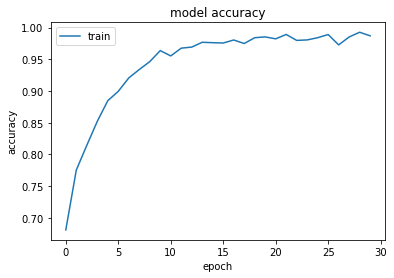

In [66]:
plt.plot(history3.history['accuracy'])
# #plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


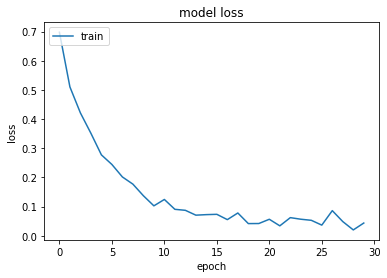

In [67]:
plt.plot(history3.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

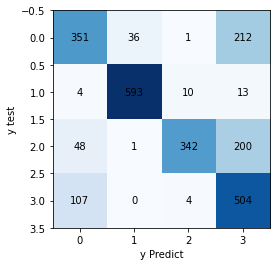

In [68]:
pred3 = np.argmax(model3.predict(test_images),axis=1)
cm3 = confusion_matrix(test_labels, pred3)
# Plot confusion matrix
plt.imshow(cm3,interpolation='none',cmap='Blues')
for (i, j), z in np.ndenumerate(cm3):
    plt.text(j, i, z, ha='center', va='center')
plt.xlabel("y Predict")
plt.ylabel("y test")
plt.grid(False)
plt.show()

In [69]:
model3.compile(optimizer = "adam" , loss = 'sparse_categorical_crossentropy' , metrics = ['accuracy'])
history3 = model3.fit(train_images, train_labels, batch_size = 32, epochs = 20, validation_data=(val_images, val_labels))

Epoch 1/20
243/243 [==============================] - 176s 723ms/step - loss: 0.0456 - accuracy: 0.9871 - val_loss: 0.2615 - val_accuracy: 0.9475
Epoch 2/20
243/243 [==============================] - 188s 775ms/step - loss: 0.0267 - accuracy: 0.9925 - val_loss: 0.3750 - val_accuracy: 0.9336
Epoch 3/20
243/243 [==============================] - 184s 757ms/step - loss: 0.0423 - accuracy: 0.9887 - val_loss: 0.2573 - val_accuracy: 0.9527
Epoch 4/20
243/243 [==============================] - 185s 759ms/step - loss: 0.0785 - accuracy: 0.9751 - val_loss: 0.2486 - val_accuracy: 0.9419
Epoch 5/20
243/243 [==============================] - 181s 747ms/step - loss: 0.0225 - accuracy: 0.9925 - val_loss: 0.2645 - val_accuracy: 0.9532
Epoch 6/20
243/243 [==============================] - 181s 745ms/step - loss: 0.0371 - accuracy: 0.9901 - val_loss: 0.2369 - val_accuracy: 0.9496
Epoch 7/20
243/243 [==============================] - 181s 744ms/step - loss: 0.0179 - accuracy: 0.9941 - val_loss: 0.3112 -

In [70]:
score3 = model3.evaluate(test_images,test_labels)
print(score3)

76/76 [==============================] - 16s 207ms/step - loss: 1.8914 - accuracy: 0.7609
[1.8914127349853516, 0.7609233260154724]


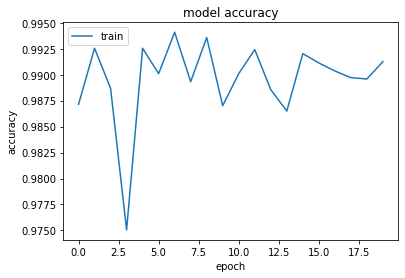

In [71]:
plt.plot(history3.history['accuracy'])
# #plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


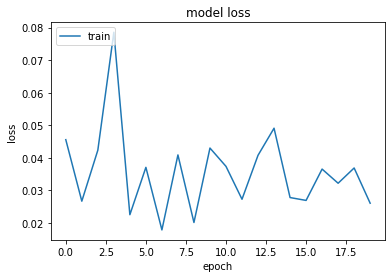

In [72]:
plt.plot(history3.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

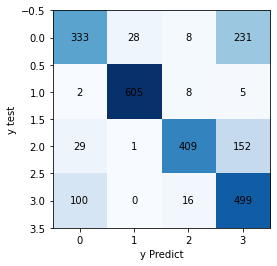

In [73]:
pred3 = np.argmax(model3.predict(test_images),axis=1)
cm3 = confusion_matrix(test_labels, pred3)
# Plot confusion matrix
plt.imshow(cm3,interpolation='none',cmap='Blues')
for (i, j), z in np.ndenumerate(cm3):
    plt.text(j, i, z, ha='center', va='center')
plt.xlabel("y Predict")
plt.ylabel("y test")
plt.grid(False)
plt.show()

In [74]:
model3.compile(optimizer = "adam" , loss = 'sparse_categorical_crossentropy' , metrics = ['accuracy'])
history3 = model3.fit(train_images, train_labels, batch_size = 32, epochs = 20, validation_data=(val_images, val_labels))

Epoch 1/20
243/243 [==============================] - 178s 734ms/step - loss: 0.0419 - accuracy: 0.9907 - val_loss: 0.2667 - val_accuracy: 0.9511
Epoch 2/20
243/243 [==============================] - 182s 749ms/step - loss: 0.0379 - accuracy: 0.9902 - val_loss: 0.3375 - val_accuracy: 0.9429
Epoch 3/20
243/243 [==============================] - 183s 753ms/step - loss: 0.0318 - accuracy: 0.9919 - val_loss: 0.2889 - val_accuracy: 0.9295
Epoch 4/20
243/243 [==============================] - 181s 745ms/step - loss: 0.0199 - accuracy: 0.9943 - val_loss: 0.3265 - val_accuracy: 0.9511
Epoch 5/20
243/243 [==============================] - 181s 744ms/step - loss: 0.0368 - accuracy: 0.9889 - val_loss: 0.3790 - val_accuracy: 0.9290
Epoch 6/20
243/243 [==============================] - 181s 745ms/step - loss: 0.0455 - accuracy: 0.9875 - val_loss: 0.2210 - val_accuracy: 0.9460
Epoch 7/20
243/243 [==============================] - 181s 745ms/step - loss: 0.0231 - accuracy: 0.9937 - val_loss: 0.2806 -

In [75]:
score3 = model3.evaluate(test_images,test_labels)
print(score3)

76/76 [==============================] - 16s 208ms/step - loss: 3.1291 - accuracy: 0.7679
[3.1290760040283203, 0.7679307460784912]


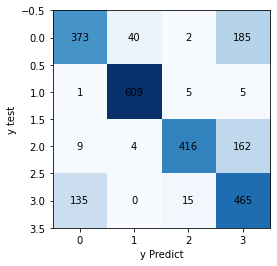

In [76]:
pred3 = np.argmax(model3.predict(test_images),axis=1)
cm3 = confusion_matrix(test_labels, pred3)
# Plot confusion matrix
plt.imshow(cm3,interpolation='none',cmap='Blues')
for (i, j), z in np.ndenumerate(cm3):
    plt.text(j, i, z, ha='center', va='center')
plt.xlabel("y Predict")
plt.ylabel("y test")
plt.grid(False)
plt.show()

CNN

In [79]:
model4 = Sequential()

model4.add(Conv2D(32, (3, 3), input_shape=(160,120, 3), activation='relu'))
model4.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model4.add(Dropout(0.05))

model4.add(Conv2D(32, (3, 3), activation='relu'))
model4.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model4.add(Dropout(0.05))

model4.add(Conv2D(48, (3, 3),activation='relu'))
model4.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model4.add(Dropout(0.2))

model4.add(Conv2D(48, (4, 4), activation='relu'))
model4.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model4.add(Dropout(0.2))

model4.add(Flatten())

model4.add(Dense(128, activation='relu'))
model4.add(Dropout(0.2))

model4.add(Dense(64, activation='relu'))
model4.add(Dropout(0.2))

model4.add(Dense(4, activation="softmax"))
model4.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_62 (Conv2D)          (None, 158, 118, 32)      896       
                                                                 
 max_pooling2d_44 (MaxPoolin  (None, 79, 59, 32)       0         
 g2D)                                                            
                                                                 
 dropout_44 (Dropout)        (None, 79, 59, 32)        0         
                                                                 
 conv2d_63 (Conv2D)          (None, 77, 57, 32)        9248      
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 38, 28, 32)       0         
 g2D)                                                            
                                                                 
 dropout_45 (Dropout)        (None, 38, 28, 32)      

In [81]:
model4.compile(optimizer = "adam" , loss = 'sparse_categorical_crossentropy' , metrics = ['accuracy'])
history4 = model4.fit(train_images, train_labels, batch_size = 32, epochs = 20, validation_data=(val_images, val_labels))

Epoch 1/20
243/243 [==============================] - 84s 345ms/step - loss: 1.0146 - accuracy: 0.5392 - val_loss: 0.8087 - val_accuracy: 0.6517
Epoch 2/20
243/243 [==============================] - 68s 282ms/step - loss: 0.7483 - accuracy: 0.6753 - val_loss: 0.5951 - val_accuracy: 0.7315
Epoch 3/20
243/243 [==============================] - 52s 212ms/step - loss: 0.5895 - accuracy: 0.7432 - val_loss: 0.4625 - val_accuracy: 0.8200
Epoch 4/20
243/243 [==============================] - 56s 231ms/step - loss: 0.4981 - accuracy: 0.7914 - val_loss: 0.4322 - val_accuracy: 0.8205
Epoch 5/20
243/243 [==============================] - 54s 220ms/step - loss: 0.4162 - accuracy: 0.8297 - val_loss: 0.3481 - val_accuracy: 0.8627
Epoch 6/20
243/243 [==============================] - 52s 213ms/step - loss: 0.3626 - accuracy: 0.8561 - val_loss: 0.2944 - val_accuracy: 0.8771
Epoch 7/20
243/243 [==============================] - 51s 209ms/step - loss: 0.3089 - accuracy: 0.8768 - val_loss: 0.2741 - val_ac

In [82]:
score4 = model4.evaluate(test_images,test_labels)
print(score4)

76/76 [==============================] - 3s 39ms/step - loss: 0.8383 - accuracy: 0.7807
[0.8383027911186218, 0.7807089686393738]


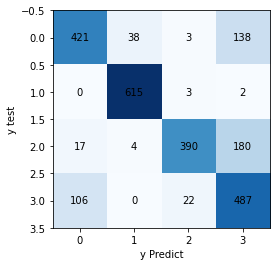

In [85]:
pred4 = np.argmax(model4.predict(test_images),axis=1)
cm4 = confusion_matrix(test_labels, pred4)
# Plot confusion matrix
plt.imshow(cm4,interpolation='none',cmap='Blues')
for (i, j), z in np.ndenumerate(cm4):
    plt.text(j, i, z, ha='center', va='center')
plt.xlabel("y Predict")
plt.ylabel("y test")
plt.grid(False)
plt.show()

In [86]:
model4.compile(optimizer = "adam" , loss = 'sparse_categorical_crossentropy' , metrics = ['accuracy'])
history4 = model4.fit(train_images, train_labels, batch_size = 32, epochs = 10, validation_data=(val_images, val_labels))

Epoch 1/10
243/243 [==============================] - 54s 219ms/step - loss: 0.0803 - accuracy: 0.9708 - val_loss: 0.0936 - val_accuracy: 0.9697
Epoch 2/10
243/243 [==============================] - 53s 217ms/step - loss: 0.0699 - accuracy: 0.9758 - val_loss: 0.1497 - val_accuracy: 0.9552
Epoch 3/10
243/243 [==============================] - 51s 210ms/step - loss: 0.0812 - accuracy: 0.9735 - val_loss: 0.1106 - val_accuracy: 0.9619
Epoch 4/10
243/243 [==============================] - 51s 211ms/step - loss: 0.0689 - accuracy: 0.9751 - val_loss: 0.1040 - val_accuracy: 0.9671
Epoch 5/10
243/243 [==============================] - 51s 211ms/step - loss: 0.0687 - accuracy: 0.9765 - val_loss: 0.1187 - val_accuracy: 0.9640
Epoch 6/10
243/243 [==============================] - 51s 212ms/step - loss: 0.0586 - accuracy: 0.9781 - val_loss: 0.1119 - val_accuracy: 0.9624
Epoch 7/10
243/243 [==============================] - 52s 212ms/step - loss: 0.0647 - accuracy: 0.9758 - val_loss: 0.1408 - val_ac

In [87]:
score4 = model4.evaluate(test_images,test_labels)
print(score4)

76/76 [==============================] - 3s 43ms/step - loss: 0.9033 - accuracy: 0.7869
[0.903338611125946, 0.7868919968605042]


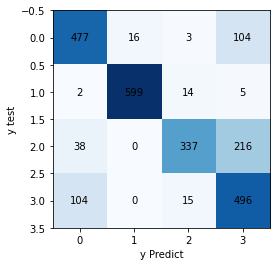

In [88]:
pred4 = np.argmax(model4.predict(test_images),axis=1)
cm4 = confusion_matrix(test_labels, pred4)
# Plot confusion matrix
plt.imshow(cm4,interpolation='none',cmap='Blues')
for (i, j), z in np.ndenumerate(cm4):
    plt.text(j, i, z, ha='center', va='center')
plt.xlabel("y Predict")
plt.ylabel("y test")
plt.grid(False)
plt.show()

In [89]:
model4.compile(optimizer = "adam" , loss = 'sparse_categorical_crossentropy' , metrics = ['accuracy'])
history4 = model4.fit(train_images, train_labels, batch_size = 32, epochs = 10, validation_data=(val_images, val_labels))

Epoch 1/10
243/243 [==============================] - 55s 224ms/step - loss: 0.0628 - accuracy: 0.9787 - val_loss: 0.1177 - val_accuracy: 0.9588
Epoch 2/10
243/243 [==============================] - 54s 224ms/step - loss: 0.0556 - accuracy: 0.9798 - val_loss: 0.0935 - val_accuracy: 0.9722
Epoch 3/10
243/243 [==============================] - 54s 222ms/step - loss: 0.0498 - accuracy: 0.9828 - val_loss: 0.0967 - val_accuracy: 0.9758
Epoch 4/10
243/243 [==============================] - 54s 223ms/step - loss: 0.0704 - accuracy: 0.9780 - val_loss: 0.0884 - val_accuracy: 0.9686
Epoch 5/10
243/243 [==============================] - 52s 214ms/step - loss: 0.0365 - accuracy: 0.9884 - val_loss: 0.0885 - val_accuracy: 0.9743
Epoch 6/10
243/243 [==============================] - 52s 216ms/step - loss: 0.0470 - accuracy: 0.9834 - val_loss: 0.1054 - val_accuracy: 0.9697
Epoch 7/10
243/243 [==============================] - 54s 221ms/step - loss: 0.0487 - accuracy: 0.9821 - val_loss: 0.0924 - val_ac

In [90]:
score4 = model4.evaluate(test_images,test_labels)
print(score4)

76/76 [==============================] - 3s 43ms/step - loss: 0.8537 - accuracy: 0.7939
[0.8537235260009766, 0.793899416923523]


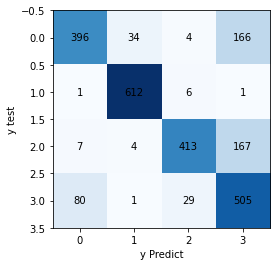

In [91]:
pred4 = np.argmax(model4.predict(test_images),axis=1)
cm4 = confusion_matrix(test_labels, pred4)
# Plot confusion matrix
plt.imshow(cm4,interpolation='none',cmap='Blues')
for (i, j), z in np.ndenumerate(cm4):
    plt.text(j, i, z, ha='center', va='center')
plt.xlabel("y Predict")
plt.ylabel("y test")
plt.grid(False)
plt.show()

In [92]:
model5 = Sequential()

model5.add(Conv2D(64, (3, 3), input_shape=(160,120, 3), activation='relu'))
model5.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model5.add(Dropout(0.1))

model5.add(Conv2D(128, (3, 3), activation='relu'))
model5.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model5.add(Dropout(0.1))

model5.add(Conv2D(64, (3, 3),activation='relu'))
model5.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model5.add(Dropout(0.2))

model5.add(Conv2D(128, (4, 4), activation='relu'))
model5.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model5.add(Dropout(0.2))

model5.add(Flatten())

model5.add(Dense(128, activation='relu'))
model5.add(Dropout(0.2))

model5.add(Dense(64, activation='relu'))
model5.add(Dropout(0.2))

model5.add(Dense(4, activation="softmax"))
model5.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_66 (Conv2D)          (None, 158, 118, 64)      1792      
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 79, 59, 64)       0         
 g2D)                                                            
                                                                 
 dropout_50 (Dropout)        (None, 79, 59, 64)        0         
                                                                 
 conv2d_67 (Conv2D)          (None, 77, 57, 128)       73856     
                                                                 
 max_pooling2d_49 (MaxPoolin  (None, 38, 28, 128)      0         
 g2D)                                                            
                                                                 
 dropout_51 (Dropout)        (None, 38, 28, 128)     

In [93]:
model5.compile(optimizer = "adam" , loss = 'sparse_categorical_crossentropy' , metrics = ['accuracy'])
history5 = model5.fit(train_images, train_labels, batch_size = 32, epochs = 20, validation_data=(val_images, val_labels))

Epoch 1/20
243/243 [==============================] - 134s 551ms/step - loss: 1.0500 - accuracy: 0.5158 - val_loss: 0.7362 - val_accuracy: 0.6662
Epoch 2/20
243/243 [==============================] - 134s 551ms/step - loss: 0.7296 - accuracy: 0.6734 - val_loss: 0.5838 - val_accuracy: 0.7659
Epoch 3/20
243/243 [==============================] - 135s 555ms/step - loss: 0.5814 - accuracy: 0.7519 - val_loss: 0.5062 - val_accuracy: 0.7906
Epoch 4/20
243/243 [==============================] - 133s 545ms/step - loss: 0.4764 - accuracy: 0.7990 - val_loss: 0.3934 - val_accuracy: 0.8472
Epoch 5/20
243/243 [==============================] - 132s 545ms/step - loss: 0.4194 - accuracy: 0.8207 - val_loss: 0.3482 - val_accuracy: 0.8601
Epoch 6/20
243/243 [==============================] - 133s 547ms/step - loss: 0.3602 - accuracy: 0.8524 - val_loss: 0.2718 - val_accuracy: 0.8889
Epoch 7/20
243/243 [==============================] - 132s 544ms/step - loss: 0.3258 - accuracy: 0.8642 - val_loss: 0.2793 -

In [94]:
score5 = model5.evaluate(test_images,test_labels)
print(score5)

76/76 [==============================] - 12s 162ms/step - loss: 1.1603 - accuracy: 0.6900
[1.1602938175201416, 0.690024733543396]
